In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf 
from tensorflow import keras

import math
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import LSTM 
from keras.layers import GRU
from keras.layers import Bidirectional,MaxPooling1D,Flatten,TimeDistributed
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error 
from keras.utils.np_utils import to_categorical 
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import keras.callbacks
from scipy.ndimage import zoom
import os
# os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import tensorflow as tf
# tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [2]:
# Set max_columns output to 999
pd.set_option('display.max_columns', 999)

# Extract http://archive.ics.uci.edu/ml/machine-learning-databases/00447/ to same directory as this script

# List files
one = ['.\\data\\TS1.txt', '.\\data\\TS2.txt', '.\\data\\TS3.txt', '.\\data\\TS4.txt', '.\\data\\VS1.txt', '.\\data\\CE.txt', '.\\data\\CP.txt', '.\\data\\SE.txt']
ten = ['.\\data\\FS1.txt', '.\\data\\FS2.txt']
hundred = ['.\\data\\PS1.txt', '.\\data\\PS2.txt', '.\\data\\PS3.txt', '.\\data\\PS4.txt', '.\\data\\PS5.txt', '.\\data\\PS6.txt', '.\\data\\EPS1.txt']

# Parse condition profiles
df_profile = pd.read_table('.\\data\\profile.txt', header=None)
df_profile = df_profile.values.reshape(2205, 1, 5)
df_profile = zoom(df_profile, (1,6000,1))

# Parse 1 Hz measurements
df_one =  np.stack([pd.read_table(x, header=None) for x in one], axis=2)
df_one = zoom(df_one, (1, 100, 1))

# Parse 10 Hz measurements
df_ten =  np.stack([pd.read_table(x, header=None) for x in ten], axis=2)
df_ten = zoom(df_ten, (1, 10, 1))

# Parse 100 Hz measurements
df_hundred = np.stack([pd.read_table(x, header=None) for x in hundred], axis=2)

# Concatenate all data
df = np.concatenate([df_one, df_ten, df_hundred], axis=2)




In [35]:
# Normalize the data  
# df=(df - np.mean(df, axis=0)) / np.std(df, axis=0) 

(2205, 6000, 17)

In [3]:
# Split data into training, validation, and test sets
val = 0.2
test = 0.1
train = 1 - val - test

X_train = df[:int(train*df.shape[0])+1:,::,::]  # [i not in [1] for i in range(df.shape[2])]]
X_val = df[int(train*df.shape[0])+1:int(train*df.shape[0])+int(val*df.shape[0])+1:,::,::]  # [i not in [1] for i in range(df.shape[2])]]
X_test = df[int(train*df.shape[0])+int(val*df.shape[0])+1::,::,::]  # [i not in [1] for i in range(df.shape[2])]]

oh_target = (np.arange(df_profile[:,0,1].max()+1) == df_profile[:,0,1][...,None]).astype(int)
oh_target = np.delete(oh_target,np.where(~oh_target.any(axis=0))[0], axis=1)

y_train = oh_target[:int(train*oh_target.shape[0])+1:,]
y_val = oh_target[int(train*oh_target.shape[0])+1:int(train*oh_target.shape[0])+int(val*oh_target.shape[0])+1:,]
y_test = oh_target[int(train*oh_target.shape[0])+int(val*oh_target.shape[0])+1::,]



In [57]:
#verify shape for each dataset
X_train.shape,X_val.shape,X_test.shape,y_train.shape,y_val.shape,y_test.shape

((1544, 6000, 17),
 (441, 6000, 17),
 (220, 6000, 17),
 (1544, 4),
 (441, 4),
 (220, 4))

In [60]:
len(X_train)

1544

# Use Keras

In [6]:
# create and fit the baseline model
# LSTM RNN
model_0 = Sequential()
model_0.add(LSTM(4))
model_0.add(Dense(y_train.shape[1]))
model_0.add(Activation('softmax'))
model_0.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])


Train on 1544 samples, validate on 441 samples
Epoch 1/10
 - 13s - loss: 1.4138 - acc: 0.1554 - val_loss: 1.4119 - val_acc: 0.1655
Epoch 2/10
 - 13s - loss: 1.4126 - acc: 0.1554 - val_loss: 1.4107 - val_acc: 0.1655
Epoch 3/10
 - 14s - loss: 1.4114 - acc: 0.1554 - val_loss: 1.4096 - val_acc: 0.1655
Epoch 4/10
 - 14s - loss: 1.4103 - acc: 0.1554 - val_loss: 1.4085 - val_acc: 0.1655
Epoch 5/10
 - 15s - loss: 1.4091 - acc: 0.1554 - val_loss: 1.4074 - val_acc: 0.1655
Epoch 6/10
 - 15s - loss: 1.4079 - acc: 0.1554 - val_loss: 1.4063 - val_acc: 0.1655
Epoch 7/10
 - 16s - loss: 1.4068 - acc: 0.1554 - val_loss: 1.4052 - val_acc: 0.1655
Epoch 8/10
 - 17s - loss: 1.4056 - acc: 0.1554 - val_loss: 1.4041 - val_acc: 0.1655
Epoch 9/10
 - 18s - loss: 1.4045 - acc: 0.1554 - val_loss: 1.4030 - val_acc: 0.1655
Epoch 10/10
 - 17s - loss: 1.4033 - acc: 0.1554 - val_loss: 1.4019 - val_acc: 0.1655


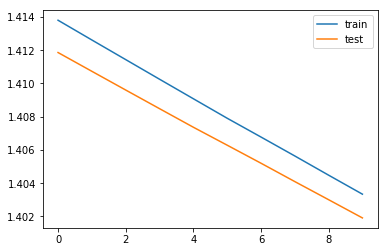

In [8]:
#fit model  
#evaluation for the baseline model validation dataset
history0 = model_0.fit(X_train, y_train, epochs=10, batch_size=len(X_train),
                    validation_data=(X_val, y_val), verbose=2, shuffle=False)

plt.plot(history0.history['loss'], label='train')
plt.plot(history0.history['val_loss'], label='test')
plt.legend()
plt.show() 

In [9]:
predictions_0= model_0.predict(X_val, verbose=0)
print(predictions_0[:1])

[[0.30039635 0.29818407 0.14568393 0.25573555]]


In [4]:
# model_0.save('DaiyiD_model_Keras_0.h5')

In [10]:
# create and fit model 1
# LSTM RNN with dropout
model_01 = Sequential()
model_01.add(LSTM(10, dropout=0.2, recurrent_dropout=0.2))
model_01.add(Dense(y_train.shape[1]))
model_01.add(Activation('softmax'))
model_01.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
#fit model  


Train on 1544 samples, validate on 441 samples
Epoch 1/25
 - 88s - loss: 1.5627 - acc: 0.2196 - val_loss: 1.6294 - val_acc: 0.1655
Epoch 2/25
 - 162s - loss: 1.5835 - acc: 0.2144 - val_loss: 1.6281 - val_acc: 0.1655
Epoch 3/25
 - 172s - loss: 1.5917 - acc: 0.2066 - val_loss: 1.6266 - val_acc: 0.1655
Epoch 4/25
 - 175s - loss: 1.5639 - acc: 0.2247 - val_loss: 1.6251 - val_acc: 0.1655
Epoch 5/25
 - 181s - loss: 1.5590 - acc: 0.2176 - val_loss: 1.6237 - val_acc: 0.1655
Epoch 6/25
 - 194s - loss: 1.5497 - acc: 0.2280 - val_loss: 1.6222 - val_acc: 0.1655
Epoch 7/25
 - 203s - loss: 1.5504 - acc: 0.2163 - val_loss: 1.6208 - val_acc: 0.1655
Epoch 8/25
 - 210s - loss: 1.5613 - acc: 0.2215 - val_loss: 1.6193 - val_acc: 0.1655
Epoch 9/25
 - 215s - loss: 1.5539 - acc: 0.2234 - val_loss: 1.6179 - val_acc: 0.1655
Epoch 10/25
 - 221s - loss: 1.5419 - acc: 0.2280 - val_loss: 1.6164 - val_acc: 0.1655
Epoch 11/25
 - 221s - loss: 1.5473 - acc: 0.2150 - val_loss: 1.6150 - val_acc: 0.1655
Epoch 12/25
 - 22

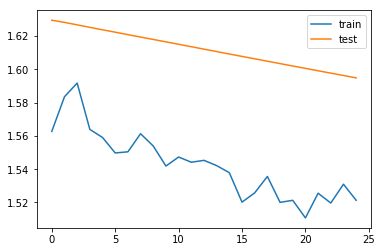

In [11]:
#fit model  
#evaluation for the baseline model validation dataset
history_01 = model_01.fit(X_train, y_train, epochs=25, batch_size=len(X_train),
                    validation_data=(X_val, y_val), verbose=2, shuffle=False)

plt.plot(history_01.history['loss'], label='train')
plt.plot(history_01.history['val_loss'], label='test')
plt.legend()
plt.show() 

In [13]:
predictions_01= model_01.predict(X_val, verbose=0)
print(predictions_01[:1])

[[0.4076443  0.23425972 0.20270586 0.15539016]]


In [26]:
# create and fit model 2
# LSTM RNN with Sgd optimizer
model_02 = Sequential()
model_02 .add(LSTM(4))
model_02 .add(Dense(y_train.shape[1]))
model_02 .add(Activation('softmax'))
model_02 .compile(loss='categorical_crossentropy', optimizer='sgd',metrics=['accuracy'])


Train on 1544 samples, validate on 441 samples
Epoch 1/20
 - 87s - loss: 1.3968 - acc: 0.1554 - val_loss: 1.3930 - val_acc: 0.1655
Epoch 2/20
 - 88s - loss: 1.3945 - acc: 0.1554 - val_loss: 1.3908 - val_acc: 0.1655
Epoch 3/20
 - 90s - loss: 1.3922 - acc: 0.1554 - val_loss: 1.3887 - val_acc: 0.1655
Epoch 4/20
 - 92s - loss: 1.3899 - acc: 0.1554 - val_loss: 1.3866 - val_acc: 0.1655
Epoch 5/20
 - 91s - loss: 1.3877 - acc: 0.1554 - val_loss: 1.3845 - val_acc: 0.1655
Epoch 6/20
 - 96s - loss: 1.3854 - acc: 0.1554 - val_loss: 1.3824 - val_acc: 0.1655
Epoch 7/20
 - 95s - loss: 1.3832 - acc: 0.1554 - val_loss: 1.3804 - val_acc: 0.1655
Epoch 8/20
 - 94s - loss: 1.3811 - acc: 0.1554 - val_loss: 1.3784 - val_acc: 0.1655
Epoch 9/20
 - 96s - loss: 1.3789 - acc: 0.1554 - val_loss: 1.3764 - val_acc: 0.1655
Epoch 10/20
 - 96s - loss: 1.3768 - acc: 0.1554 - val_loss: 1.3744 - val_acc: 0.1655
Epoch 11/20
 - 102s - loss: 1.3747 - acc: 0.1554 - val_loss: 1.3724 - val_acc: 0.1655
Epoch 12/20
 - 97s - loss:

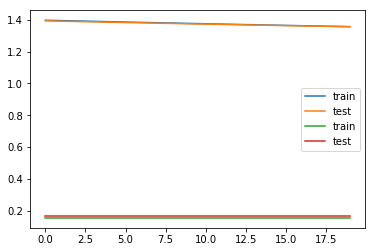

In [27]:
#fit model  
#evaluation for the baseline model validation dataset
history_02 = model_02.fit(X_train, y_train, epochs=20, batch_size=len(X_train),
                          validation_data=(X_val, y_val), verbose=2, shuffle=False)



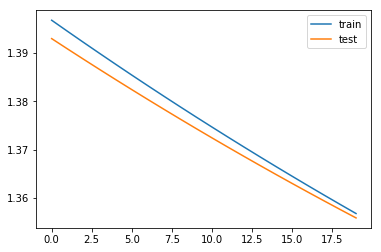

In [28]:
plt.plot(history_02.history['loss'], label='train')
plt.plot(history_02.history['val_loss'], label='test')
plt.legend()
plt.show() 

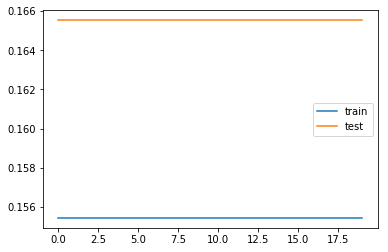

In [29]:
plt.plot(history_02.history['acc'], label='train')
plt.plot(history_02.history['val_acc'], label='test')
plt.legend()
plt.show() 

In [32]:
predictions_02= model_02.predict(X_val, verbose=0)
print(predictions_02[:1])

[[0.30730298 0.20900938 0.20495114 0.27873647]]


In [60]:
model_1.save('DaiyiD_model_Keras_1.h5')

In [17]:
# create and fit the model 3
# GRU
model_03 = Sequential()
model_03.add(GRU(4))
model_03.add(Dense(y_train.shape[1]))
model_03.add(Activation('softmax'))
model_03.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

Train on 1544 samples, validate on 441 samples
Epoch 1/25
 - 91s - loss: 1.7013 - acc: 0.1554 - val_loss: 1.7049 - val_acc: 0.1587
Epoch 2/25
 - 90s - loss: 1.6986 - acc: 0.1554 - val_loss: 1.7019 - val_acc: 0.1587
Epoch 3/25
 - 94s - loss: 1.6956 - acc: 0.1554 - val_loss: 1.6988 - val_acc: 0.1587
Epoch 4/25
 - 100s - loss: 1.6924 - acc: 0.1554 - val_loss: 1.6953 - val_acc: 0.1587
Epoch 5/25
 - 102s - loss: 1.6889 - acc: 0.1554 - val_loss: 1.6921 - val_acc: 0.1587
Epoch 6/25
 - 99s - loss: 1.6856 - acc: 0.1554 - val_loss: 1.6886 - val_acc: 0.1587
Epoch 7/25
 - 102s - loss: 1.6821 - acc: 0.1554 - val_loss: 1.6852 - val_acc: 0.1587
Epoch 8/25
 - 94s - loss: 1.6787 - acc: 0.1554 - val_loss: 1.6819 - val_acc: 0.1587
Epoch 9/25
 - 107s - loss: 1.6753 - acc: 0.1554 - val_loss: 1.6785 - val_acc: 0.1587
Epoch 10/25
 - 100s - loss: 1.6719 - acc: 0.1554 - val_loss: 1.6752 - val_acc: 0.1587
Epoch 11/25
 - 108s - loss: 1.6685 - acc: 0.1554 - val_loss: 1.6718 - val_acc: 0.1587
Epoch 12/25
 - 102s -

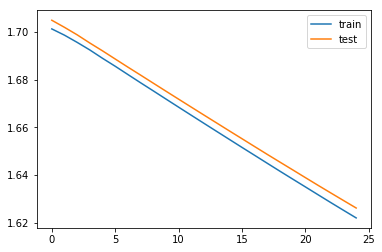

In [18]:
#fit model  
#evaluation for the baseline model validation dataset
history_03 = model_03.fit(X_train, y_train, epochs=25, batch_size=len(X_train),
                    validation_data=(X_val, y_val), verbose=2, shuffle=False)

plt.plot(history_03.history['loss'], label='train')
plt.plot(history_03.history['val_loss'], label='test')
plt.legend()
plt.show() 

In [19]:
predictions_03= model_03.predict(X_val, verbose=0)
print(predictions_03[:1])

[[0.07837518 0.56002057 0.15597823 0.20562601]]


In [61]:
# model_2.save('DaiyiD_model_Keras_2.h5')

In [4]:
# create and fit the model 4
# BiLSTM + CNN

model_04 = Sequential() 
model_04.add(Bidirectional(LSTM(4, return_sequences=True)))
model_04.add(TimeDistributed(Dense(4)))
model_04.add(Activation('softplus'))
model_04.add(MaxPooling1D(5))
model_04.add(Flatten())
model_04.add(Dense(y_train.shape[1]))
model_04.add(Activation('softmax'))
model_04.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Train on 1544 samples, validate on 441 samples
Epoch 1/25
 - 191s - loss: 1.3116 - acc: 0.5337 - val_loss: 2.9173 - val_acc: 0.5170
Epoch 2/25
 - 230s - loss: 2.8151 - acc: 0.5337 - val_loss: 1.8149 - val_acc: 0.5170
Epoch 3/25
 - 213s - loss: 1.7587 - acc: 0.5337 - val_loss: 1.6755 - val_acc: 0.1655
Epoch 4/25
 - 228s - loss: 1.6766 - acc: 0.1554 - val_loss: 1.7483 - val_acc: 0.1587
Epoch 5/25
 - 245s - loss: 1.7627 - acc: 0.1554 - val_loss: 1.5335 - val_acc: 0.1587
Epoch 6/25
 - 132s - loss: 1.5343 - acc: 0.1554 - val_loss: 1.3916 - val_acc: 0.5170
Epoch 7/25
 - 179s - loss: 1.3670 - acc: 0.5337 - val_loss: 1.5038 - val_acc: 0.5170
Epoch 8/25
 - 192s - loss: 1.4575 - acc: 0.5337 - val_loss: 1.6439 - val_acc: 0.5170
Epoch 9/25
 - 171s - loss: 1.5905 - acc: 0.5337 - val_loss: 1.5090 - val_acc: 0.5170
Epoch 10/25
 - 152s - loss: 1.4634 - acc: 0.5337 - val_loss: 1.2843 - val_acc: 0.5170
Epoch 11/25
 - 144s - loss: 1.2571 - acc: 0.5337 - val_loss: 1.3379 - val_acc: 0.5170
Epoch 12/25
 - 1

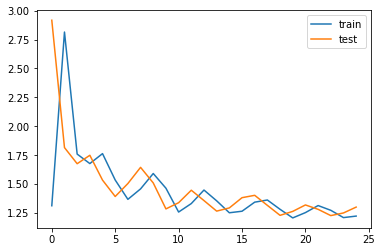

In [5]:
#fit model  
#evaluation for the baseline model validation dataset
history_04 = model_04.fit(X_train, y_train, epochs=25, batch_size=len(X_train),
                    validation_data=(X_val, y_val), verbose=2, shuffle=False)

plt.plot(history_04.history['loss'], label='train')
plt.plot(history_04.history['val_loss'], label='test')
plt.legend()
plt.show() 

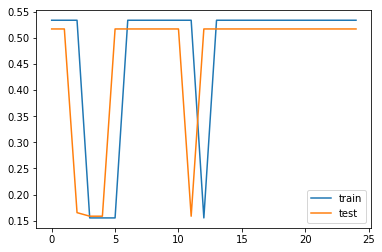

In [23]:
plt.plot(history_04.history['acc'], label='train')
plt.plot(history_04.history['val_acc'], label='test')
plt.legend()
plt.show() 

In [7]:
predictions_04= model_04.predict(X_val, verbose=0)
print(predictions_04[:1])

[[0.08390137 0.08688809 0.14768513 0.68152535]]


In [20]:
# create and fit the model 5
#LSTM with earlystopping
model_05= Sequential()
model_05.add(LSTM(4, return_sequences=True,  input_shape=(X_train.shape[1], X_train.shape[2])))
model_05.add(LSTM(4))
model_05.add(Dense(y_train.shape[1]))
model_05.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
 

In [21]:
model_05.save('model_05.h5')

Train on 1544 samples, validate on 441 samples
Epoch 1/20
 - 258s - loss: 11.1073 - acc: 0.1554 - val_loss: 10.8916 - val_acc: 0.1587
Epoch 2/20
 - 237s - loss: 11.1073 - acc: 0.1554 - val_loss: 10.8916 - val_acc: 0.1587
Epoch 3/20
 - 651s - loss: 11.1073 - acc: 0.1554 - val_loss: 10.8916 - val_acc: 0.1587


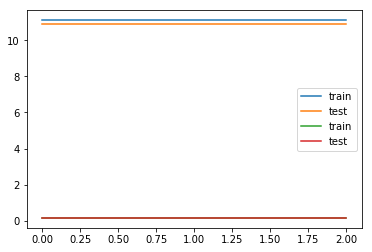

In [24]:
# Early stopping
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='model_05.h5', monitor='val_loss', save_best_only=True)]
history_05 = model_05.fit(X_train, y_train, epochs=20, batch_size=len(X_train),
                    validation_data=(X_val, y_val), verbose=2, shuffle=False,callbacks=callbacks)


 

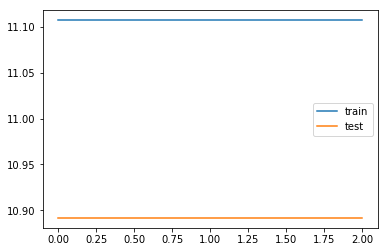

In [30]:
plt.plot(history_05.history['loss'], label='train')
plt.plot(history_05.history['val_loss'], label='test')
plt.legend()
plt.show() 

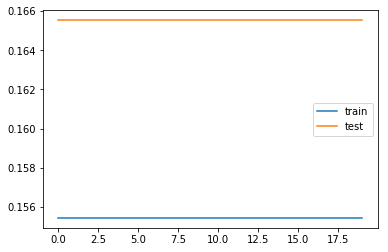

In [31]:
plt.plot(history_02.history['acc'], label='train')
plt.plot(history_02.history['val_acc'], label='test')
plt.legend()
plt.show() 

In [25]:
predictions_05= model_05.predict(X_val, verbose=0)
print(predictions_05[:1])

[[-0.14008465  0.22545236 -0.2673509   0.1603829 ]]
